# Curve Fitting Tool (Bivariate Functions)

<strong>This Jupyter Notebook serves as a tool for obtaining the optimum parameters of a defined bivariate function to fit some input data. This tool is valid only for bivariate functions.</strong>

# 1. Install necessary libraries and import required modules

In [1]:
#import sys
#!conda install --yes --prefix {sys.prefix} ipywidgets=7.5.1

In [2]:
#!conda install --yes --prefix {sys.prefix} numpy
#!conda install --yes --prefix {sys.prefix} pandas
#!conda install --yes --prefix {sys.prefix} matplotlib
#!conda install --yes --prefix {sys.prefix} scipy
#!conda install --yes --prefix {sys.prefix} xlrd
#!conda install --yes --prefix {sys.prefix} IPython

In [65]:
#!jupyter nbextension enable --py widgetsnbextension --sys-prefix
#!jupyter labextension install @jupyter-widgets/jupyterlab-manager
%matplotlib inline

In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as opt
import ipywidgets as widgets
from IPython.display import display
from mpl_toolkits.mplot3d import Axes3D

# 2. Import the data file

<strong>Input the name and path of the file where your dataset is stored. The input file should be a .xlsx file with the data located in the first, second and third column in the form [x, y, z]. The data for each curve related to the family of curves should be appended at the end of the previous curve for each constant value of y, being this variable the varying parameter in the family of curves. </strong>

In [57]:
file_name = 'xy_dataset_SCC_2.xlsx'

**Input the name of the Excel sheet where the data is located. The code assumes the data headings are located in the first row.**

In [58]:
sheet_name = 'Sheet1'

In [59]:
df = pd.read_excel(str(file_name), sheet_name=sheet_name, header=0)

# 3. Explore and prepare the data

In [61]:
df.head(15)
df.drop(["Unnamed: 3"], axis=1)

,x,y,z
0,0.799908,288.15,-2.197141
1,0.802391,288.15,-2.190013
2,0.806294,288.15,-2.182881
3,0.810196,288.15,-2.175524
4,0.814098,288.15,-2.168584
...,...,...,...
716,1.184466,300.15,-1.065920
717,1.188368,300.15,-1.060377
718,1.192270,300.15,-1.054895
719,1.196173,300.15,-1.049412


<strong>Showing some data stats and object info.</strong>

In [27]:
df.describe()

,x,y,z,Unnamed: 3
count,721.000000,721.000000,721.000000,721.000000
mean,1.000700,294.144452,-1.609785,0.206398
std,0.116166,4.008321,0.253219,0.052306
min,0.799908,288.150000,-2.197141,0.111120
25%,0.899950,290.150000,-1.790611,0.166858
50%,1.000701,294.150000,-1.607179,0.200452
75%,1.101807,298.150000,-1.427344,0.239945
max,1.199417,300.150000,-1.045281,0.351593


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 721 entries, 0 to 720
Data columns (total 4 columns):
x             721 non-null float64
y             721 non-null float64
z             721 non-null float64
Unnamed: 3    721 non-null float64
dtypes: float64(4)
memory usage: 22.7 KB


# 4. Construct the bivariate polynomial of interest

<strong>Specify order of the bivariate polynomial. As an example, if you specify an order of 2, the output polynomial will be of the form: $A_{00}x^0y^0+A_{01}x^1y^0+A_{02}x^2y^0+A_{10}x^0y^1+A_{11}x^1y^1+A_{12}x^2y^1+A_{20}x^0y^2+A_{21}x^1y^2+A_{22}x^2y^2$. On the other hand, if the bivariate polynomial of interest does not have this general form, you can specify it below as a function.</strong>

In [62]:
n = 2

<strong> Building and printing the bivariate polynomial </strong>

In [63]:
xy = []
A = []
for j in range(n + 1):
    for i in range(n + 1):
        A.append("A%i%i" % (j,i))
        xy.append("A%i%i*" % (j,i) + "x**%i*y**%i" % (i,j))
        
print('+'.join(xy))

A00*x**0*y**0+A01*x**1*y**0+A02*x**2*y**0+A10*x**0*y**1+A11*x**1*y**1+A12*x**2*y**1+A20*x**0*y**2+A21*x**1*y**2+A22*x**2*y**2


<strong> Converting dataframe columns to lists </strong>

In [70]:
xdata = df[df.columns[0]].tolist()
ydata = df[df.columns[1]].tolist()
zdata = df[df.columns[2]].tolist()

<strong> Converting lists to arrays </strong>

In [32]:
x = np.array(xdata)
y = np.array(ydata)
z = np.array(zdata)

<strong> Defining a function for the bivariate polynomial of interest </strong>

In [33]:
def function(data, A1, A2, A3, A4, B1, B2, B3, B4):

    x = data[0]
    y = data[1]

    return A1 + A2 * y*x + A3*x + A4*y + B1*(y**2) + B2*(x**2) + B3*y*(x**2) + B4* (y**2)*x

In [71]:
arg_list = ['A1', 'A2', 'A3', 'A4', 'B1', 'B2', 'B3', 'B4']

# 5. Nonlinear Least Squares Method to fit a function f(x, y), to data z

## Defining the initial values

<strong>For the algorithm to work properly initial values should be in the order of magnitude of the max 'x' and 'y' values respectively.</strong>

In [34]:
init_vals = [28.232252,-92.390491,-625.7959,207.2301,70.251642,-22.516388,-0.047796308,1.2844571]

### Parameters

<strong> f: callable. The model function, f(x, …). It must take the independent variable as the first argument and the parameters to fit as separate remaining arguments. </strong>

<strong> xdata: array_like or object. 
* The independent variable where the data is measured. Should usually be an M-length sequence or an (k,M)-shaped array for functions with k predictors, but can actually be any object. </strong>

<strong> ydata: array_like.
* The dependent data, a length M array - nominally f(xdata, ...).</strong>

<strong>p0: array_like, optional. 
* Initial guess for the parameters (length N). If None, then the initial values will all be 1 (if the number of parameters for the function can be determined using introspection, otherwise a ValueError is raised).</strong>

<strong> sigma: None or M-length sequence or MxM array, optional. Determines the uncertainty in ydata. If we define residuals as r = ydata - f(xdata, *popt), then the interpretation of sigma depends on its number of dimensions:
    
* A 1-D sigma should contain values of standard deviations of errors in ydata. In this case, the optimized function is chisq = sum((r / sigma) ** 2).
    
* A 2-D sigma should contain the covariance matrix of errors in ydata. In this case, the optimized function is chisq = r.T @ inv(sigma) @ r.
    
None (default) is equivalent of 1-D sigma filled with ones.</strong>

<strong>absolute_sigma: bool, optional.
    
* If True, sigma is used in an absolute sense and the estimated parameter covariance pcov reflects these absolute values.

* If False (default), only the relative magnitudes of the sigma values matter. The returned parameter covariance matrix pcov is based on scaling sigma by a constant factor. This constant is set by demanding that the reduced chisq for the optimal parameters popt when using the scaled sigma equals unity. In other words, sigma is scaled to match the sample variance of the residuals after the fit. Default is False. Mathematically, pcov(absolute_sigma=False) = pcov(absolute_sigma=True) * chisq(popt)/(M-N)</strong>

<strong>check_finite: bool, optional 
* If True, check that the input arrays do not contain nans of infs, and raise a ValueError if they do. Setting this parameter to False may silently produce nonsensical results if the input arrays do contain nans. Default is True.
</strong>

<strong>bounds: 2-tuple of array_like, optional 
* Lower and upper bounds on parameters. Defaults to no bounds. Each element of the tuple must be either an array with the length equal to the number of parameters, or a scalar (in which case the bound is taken to be the same for all parameters). Use np.inf with an appropriate sign to disable bounds on all or some parameters.

</strong>

<strong>method: {‘lm’, ‘trf’, ‘dogbox’}, optional 
* Method to use for optimization. See least_squares for more details. Default is ‘lm’ for unconstrained problems and ‘trf’ if bounds are provided. The method ‘lm’ won’t work when the number of observations is less than the number of variables, use ‘trf’ or ‘dogbox’ in this case.
</strong>

<strong>jac: callable, string or None, optional 
* Function with signature jac(x, ...) which computes the Jacobian matrix of the model function with respect to parameters as a dense array_like structure. It will be scaled according to provided sigma. If None (default), the Jacobian will be estimated numerically. String keywords for ‘trf’ and ‘dogbox’ methods can be used to select a finite difference scheme, see least_squares.</strong>

<strong>kwargs
* Keyword arguments passed to leastsq for method='lm' or least_squares otherwise.
</strong>

### Returns

<strong>popt: array 
* Optimal values for the parameters so that the sum of the squared residuals of f(xdata, *popt) - ydata is minimized.
</strong>

<strong>pcov: 2-D array 
* The estimated covariance of popt. The diagonals provide the variance of the parameter estimate. To compute one standard deviation errors on the parameters use perr = np.sqrt(np.diag(pcov)). How the sigma parameter affects the estimated covariance depends on absolute_sigma argument, as described above.
* If the Jacobian matrix at the solution doesn’t have a full rank, then ‘lm’ method returns a matrix filled with np.inf, on the other hand ‘trf’ and ‘dogbox’ methods use Moore-Penrose pseudoinverse to compute the covariance matrix.
</strong>

### Raises

<strong>ValueError
* if either ydata or xdata contain NaNs, or if incompatible options are used.

</strong>

<strong>RuntimeError
* if the least-squares minimization fails.

</strong>

<strong>OptimizeWarning
* if covariance of the parameters can not be estimated.

</strong>

<strong>
With method='lm', the algorithm uses the Levenberg-Marquardt algorithm through leastsq. Note that this algorithm can only deal with unconstrained problems.

    
Box constraints can be handled by methods ‘trf’ and ‘dogbox’. Refer to the docstring of least_squares for more information.
</strong>

## Obtain optimum parameters for fitting the surface. 

In [72]:
parameters, covariance = opt.curve_fit(function, [x, y], z, init_vals)

# 6. Print and visualise the results

<strong>Print the optimum coefficients for the model</strong>

In [73]:
np.set_printoptions(formatter={'float': '{: 0.15f}'.format})
print ('Optimum Model Coefficients:')
print()
i = 0
for c in parameters:
    if c > 0:
        print('%s =  %s' % (arg_list[i], c))
        i = i + 1
    else:
        print('%s = %s' % (arg_list[i], c))
        i = i + 1

Optimum Model Coefficients:

A1 =  24.75704815235068
A2 =  0.23273531633208136
A3 = -32.76573258465873
A4 = -0.23362400835020544
B1 =  0.00046864551107785447
B2 =  0.6870952716293953
B3 = -0.0029985550642339437
B4 = -0.0003894109597573806


In [76]:
# create surface function model
# setup data points for calculating surface model

In [77]:
model_x_data = np.linspace(min(x), max(x), len(xdata))
model_y_data = np.linspace(min(y), max(y), len(xdata))

In [78]:
# create coordinate arrays for vectorized evaluations

In [79]:
X, Y = np.meshgrid(model_x_data, model_y_data)

In [80]:
# calculate Z coordinate array

In [81]:
Z = function(np.array([X, Y]), *parameters)

In [82]:
# setup figure object

In [83]:
fig = plt.figure()

<Figure size 432x288 with 0 Axes>

In [84]:
# setup 3d object

In [85]:
ax = Axes3D(fig)

In [86]:
# plot surface

In [87]:
ax.plot_surface(X, Y, Z)

In [88]:
# plot input data

In [89]:
ax.scatter(x, y, z, color='red')

In [90]:
# set plot descriptions

In [91]:
ax.set_xlabel('CQ/CQdesign [-]')
ax.set_ylabel('Air inlet temperature TAir [°K]')
ax.set_zlabel('Condenser Pressure Pcond [Bar] ')
plt.show()

In [92]:
RMS = np.sqrt(np.mean((Z - z) ** 2))
print ('Residual, RMS(obs - pred):', RMS)

Residual, RMS(obs - pred): 0.21813427620546788


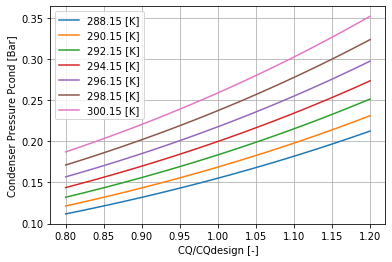

In [97]:
x = np.linspace(0.8, 1.2, 100)
T = [15+273.15, 17+273.15, 19+273.15, 21+273.15, 23+273.15, 25+273.15, 27+273.15]

Coef = [ 24.757048152350681,  0.232735316332081, -32.765732584658728,
 -0.233624008350205,  0.000468645511078,  0.687095271629395,
 -0.002998555064234, -0.000389410959757]

A1 = Coef[0]
A2 = Coef[1]
A3 = Coef[2]
A4 = Coef[3]
B1 = Coef[4]
B2 = Coef[5]
B3 = Coef[6]
B4 = Coef[7]


for T in T:

    y = A1 + A2*T*x + A3*x + A4*T + B1*(T**2) + B2*(x**2) + B3*T*(x**2) + B4* (T**2)*x

    plt.plot(x, np.exp(y), label=str(T)+' [K]')

    
    
plt.xlabel('CQ/CQdesign [-]')
plt.ylabel('Condenser Pressure Pcond [Bar]')
plt.legend()
plt.grid(True)
plt.show()